In [1]:
using Plots
using SimpleSolvers

#include("../src/WassersteinDictionaries.jl")

using LinearAlgebra
using LogExpFunctions
using WassersteinDictionaries

In [2]:
const d = 2
const n = 64

_Type = Float64
x₁ = collect(range(0,1,length=n))
x₂ = collect(range(0,1,length=n))

S = 4;

In [3]:
c = WassersteinDictionaries.get_cost_matrix_separated(n, d);

In [4]:
p = [zeros(_Type, n,n) for _ in 1:S] # input histograms

#p_vec = [zeros(_Type, n^2) for _ in 1:S] # input histograms
q = zeros(_Type, n,n)
m₀ₑ = zeros(_Type, n,n)


function p₁(x) 
    exp(-norm(x-[0.25; 0.25])^2/(2*0.04^2))
end

function p₂(x)
    exp(-norm(x-[0.75; 0.75])^2/(2*0.04^2))
end

function p₃(x)
    exp(-norm(x-[0.8; 0.3])^2/(2*0.04^2))
    #exp(-norm(x-[0.7; 0.3],2)^2/(2*0.031^2))
end

function p₄(x)
    exp(-norm(x-[0.20; 0.70])^2/(2*0.04^2))
    #exp(-norm(x-[0.30; 0.75],2)^2/(2*0.062^2))
end

function q_(x)
    exp(-norm(x-[0.38; 0.52])^2/(2*0.04^2))
end

function m_(x)
    exp(-norm(x-[0.5; 0.5])^2/(2*0.04^2))
end


for i in 1:n
    for j in 1:n
        p[1][i,j] = p₁([x₁[i]; x₂[j]])
        p[2][i,j] = p₂([x₁[i]; x₂[j]])
        p[3][i,j] = p₃([x₁[i]; x₂[j]])
        p[4][i,j] = p₄([x₁[i]; x₂[j]])
        q[i,j] = q_([x₁[i]; x₂[j]])
        m₀ₑ[i,j] = m_([x₁[i]; x₂[j]])
    end
end


for s in 1:S 
    p[s] ./= sum(p[s])
end
q ./= sum(q)
m₀ₑ ./= sum(m₀ₑ)

log_p = [WassersteinDictionaries._safe_log(p[s]) for s in 1:S]
log_q = WassersteinDictionaries._safe_log(q)

log_p_vec = [reshape(log_p[s], n^2) for s in 1:S]
log_q_vec = reshape(log_q, n^2)

c_max = maximum(maximum.(p));

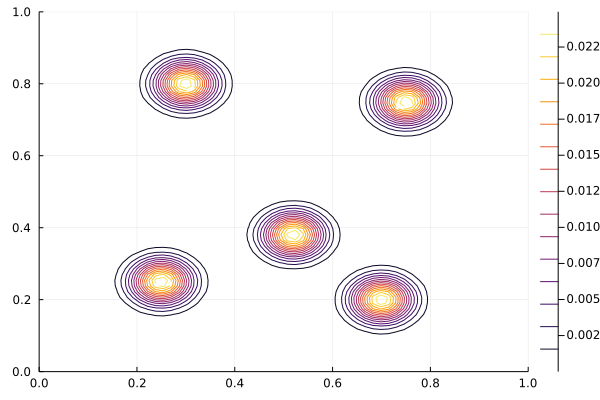

In [5]:
contour(x₁, x₂, [p, q])

# Testing separated sinkhorn

In [6]:
caches = ( MC = MatrixCache(S,n), VMC = VectorMatrixCache(S,n), VC = VectorCache(S,n) )
caches_N = ( VC = VectorCache(S,n^2) , VVC = VectorVectorCache(S,n^2) )

ε_min = (5e-3)

SP = SinkhornParameters(32, ε_min)
SPB = SinkhornParameters(32, ε_min)

SP.averaged_updates = false
SP.debias = true

k₁ = WassersteinDictionaries.get_gibbs_matrix(c, ε_min);

In [7]:
@time sinkhorn_dvg_logseparated(log_p[1], log_p[2], c, SP, caches)

  1.889674 seconds (5.05 M allocations: 231.035 MiB, 2.53% gc time, 82.84% compilation time)


0.4999999999538886

In [8]:
@time sinkhorn_dvg_separated(p[1], p[2], k₁, SP, caches)

  1.469386 seconds (4.81 M allocations: 216.915 MiB, 2.92% gc time, 99.71% compilation time)


0.4999999999538885

In [9]:
λ₀ = ones(S)/S
@time m₀ = sinkhorn_barycenter_separated(λ₀, p, k₁, SPB, caches);

  0.479668 seconds (1.32 M allocations: 58.597 MiB, 3.23% gc time, 97.28% compilation time)


In [10]:
@time log_m₀ = sinkhorn_barycenter_logseparated(λ₀, log_p, c, SPB, caches);

  1.304145 seconds (1.71 M allocations: 76.052 MiB, 2.39% gc time, 42.86% compilation time)


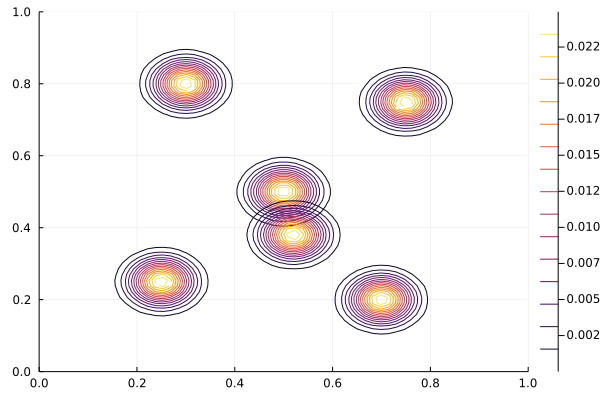

In [11]:
contour(x₁, x₂, [ [p[s] for s in 1:S ], m₀, q])

In [12]:
norm(m₀ - exp.(log_m₀), 1)

4.3956669313462776e-15

# Convergence tests

In [27]:
W₂ₑ = 0.5;
N_c = 8

ΔW₂ = zeros(N_c)
ΔW₂ₛ = zeros(N_c)
ΔW₂_log = zeros(N_c)
ΔW₂ₛ_log = zeros(N_c)

ε_min = 5e-3
ε_log = 1e-3

k₁ = WassersteinDictionaries.get_gibbs_matrix(c, ε_min);

for i in 1:N_c
    
    SP.L = i*8

    SP.averaged_updates = false
    SP.ε = ε_min
    ΔW₂[i] = abs(sinkhorn_dvg_separated(p[1], p[2], k₁, SP, caches) - W₂ₑ)
    SP.ε = ε_log
    ΔW₂_log[i] = abs(sinkhorn_dvg_logseparated(log_p[2], log_p[1], c, SP, caches) - W₂ₑ)

    SP.averaged_updates = true
    SP.ε = ε_min
    ΔW₂ₛ[i] = abs(sinkhorn_dvg_separated(p[1], p[2], k₁, SP, caches) - W₂ₑ)
    SP.ε = ε_log
    ΔW₂ₛ_log[i] = abs(sinkhorn_dvg_logseparated(log_p[1], log_p[2], c, SP, caches) - W₂ₑ)
end


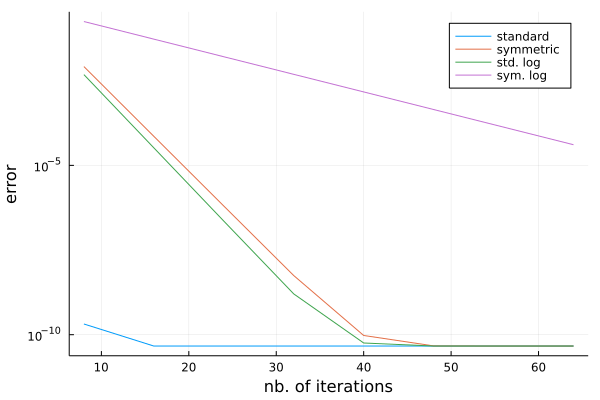

In [28]:
plot(collect(1:N_c) * 8, [ΔW₂, ΔW₂ₛ, ΔW₂_log, ΔW₂ₛ_log], 
    yaxis = :log, xlabel = "nb. of iterations", ylabel = "error", 
    label = ["standard" "symmetric" "std. log" "sym. log" ])

In [32]:
λ₀ = ones(S)/S

ε_min = 5e-3
k₁ = WassersteinDictionaries.get_gibbs_matrix(c, ε_min);
SPB.ε = ε_min
SPB.L = 512

μₑ = sinkhorn_barycenter_separated(λ₀, p, k₁, SPB, caches);

In [33]:
N_c = 16

Δ₁μ = zeros(N_c)
Δwμ = zeros(N_c)
Δ₁μ_log = zeros(N_c)

SP.L = 64
SP.averaged_updates = false

μ = zero(μₑ)

for i in 1:N_c
    
    SPB.L = i*8

    SPB.ε = ε_min
    μ = sinkhorn_barycenter_separated(λ₀, p, k₁, SPB, caches)
    Δ₁μ[i] = norm(μ - μₑ, 1)
    Δwμ[i] = sqrt( abs(sinkhorn_dvg_separated(μ, μₑ, k₁, SP, caches) ) )
end

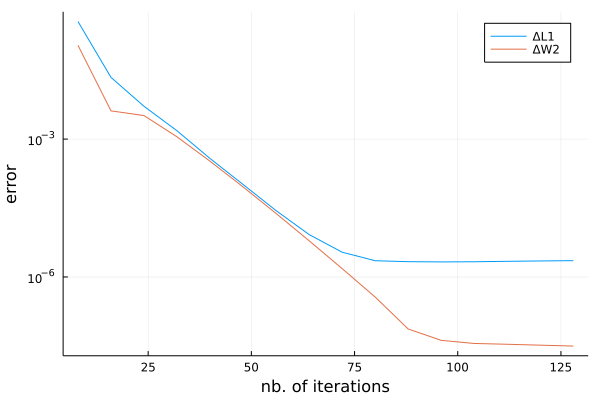

In [34]:
plot(collect(1:N_c) * 8, [Δ₁μ, Δwμ],
    label = ["ΔL1" "ΔW2"],
    yaxis = :log, xlabel = "nb. of iterations", ylabel = "error")

# Testing Optimization


In [35]:
Cₘ = maximum(maximum.(c))
Q = norm(q,2)^2

#k = get_gibbs_matrix_separated(c, ε_min)
k = copy(k₁)

function mixed_loss_separated(w::Vector{T}) where T
    μ_λ = sinkhorn_barycenter_separated(softmax(w), p, b_₀, d₀, k, SPB, caches)
    return sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches)/Cₘ + sqeuclidean(q,μ_λ)/Q
end

function l2_loss_separated(w::AbstractVector{T}) where T
    μ_λ = sinkhorn_barycenter_separated(softmax(w), p, b_₀, d₀, k, SPB, caches)
    return sqeuclidean(q, μ_λ)
end

function w2_loss_separated(w::Vector{T}) where T
    μ_λ = sinkhorn_barycenter_separated(softmax(w), p, b_₀, d₀, k, SPB, caches)
    return sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches)
end

w2_loss_separated (generic function with 1 method)

In [36]:
function initial_weights(q, p, k, SP, caches)
    w₀ = zeros((caches.MC).S)
    for i in eachindex(p)
        w₀[i] = 1/sinkhorn_dvg_separated(q, p[i], k, SP, caches)
    end
    return w₀./sum(w₀)
end

initial_weights (generic function with 1 method)

In [37]:
λ₀ = zeros(S)./S
λᵢ = initial_weights(q, p, k, SP, caches)

4-element Vector{Float64}:
 0.3068992385853619
 0.14520311709243336
 0.12259587857743508
 0.4253017657447698

In [38]:
a₀ = ones(size(p[1]))
b₀ = ones(size(p[1]))
d₀₁ = ones(size(p[1]))
d₀₂ = ones(size(p[1]))

b_₀ = [ones(size(p[s])) for s in eachindex(p)] 
d₀ = ones(size(p[1]));

In [39]:
sqrt(w2_loss_separated(zeros(S))), sqrt(w2_loss_separated(λᵢ))

(0.054405882034961994, 0.039449947059709584)

In [40]:
using ForwardDiff

In [75]:
SP.update_potentials = false
SPB.update_potentials = false

SP.averaged_updates = false

w₀ = zeros(S)

a₀ = ones(size(p[1]))
b₀ = ones(size(p[1]))
d₀₁ = ones(size(p[1]))
d₀₂ = ones(size(p[1]))
b_₀ = [ones(size(p[s])) for s in eachindex(p)] 
d₀ = ones(size(p[1]))

SP.L = 32
SPB.L = 64

function w2_loss_separated(w::Vector{T}) where T
    μ_λ = sinkhorn_barycenter_separated(softmax(w), p, b_₀, d₀, k, SPB, caches)
    return abs( sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches) )
end

x_trace = [ w₀ ]
y_trace = [ w2_loss_separated(w₀) ]

_Optimizer = Optimizer( w₀, w2_loss_separated; algorithm = BFGS(),
                        config=Options(   
                            f_reltol = (0.05)^2,
                            g_restol = 1e-8,
                            min_iterations=1,
                            max_iterations=32,
                            store_trace=true 
                        )
                    );


In [76]:
function callback(opt::Optimizer)
    #SP.update_potentials = true
    #SPB.update_potentials = true

    #loss(x)
    #value!!(objective(opt), objective(opt).x_f)

    push!(x_trace, copy(opt.result.x))
    push!(y_trace, opt.result.f)

    SP.update_potentials = false
    SPB.update_potentials = false
end

import SimpleSolvers: initialize!, meets_stopping_criteria, next_iteration!, state, solver_step!, update!, objective, warn_iteration_number

function solve_callback!(x, opt::Optimizer, callback)
    initialize!(opt, x) 

    while !meets_stopping_criteria(opt)
        next_iteration!(result(opt))
        solver_step!(x, state(opt))
        update!(opt, x)

        callback(opt)
    end

    warn_iteration_number(status(opt), config(opt))

    return x
end

solve_callback! (generic function with 1 method)

In [77]:
w̄ = zeros(S)
#@time solve!( w̄, _Optimizer )
@time solve_callback!( w̄, _Optimizer, callback )
λ̄ = softmax(w̄)

# L = 64, no warmstart, n=32
#   0.3057028068469589
#   0.16170279827868023
#   0.12629719648783708
#   0.40629719838652384
# t = 8s
# ΔL1 = 4e-7


 33.197540 seconds (615.72 k allocations: 489.225 MiB, 0.12% gc time, 0.73% compilation time)


4-element Vector{Float64}:
 0.3056428352593141
 0.1616428504449352
 0.1263571778171318
 0.40635713647861876

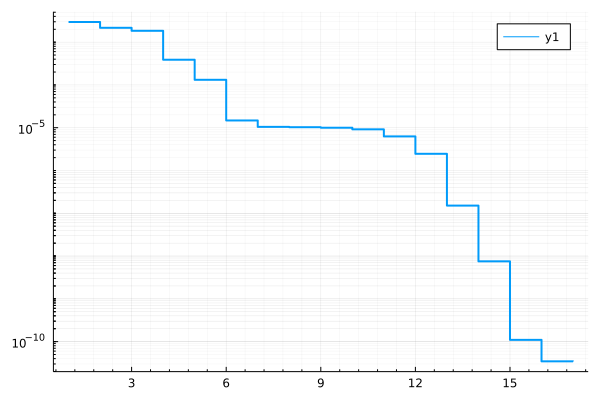

In [78]:
plot(y_trace, yaxis=:log, line=:steppost, linewidth=2, minorgrid=true)

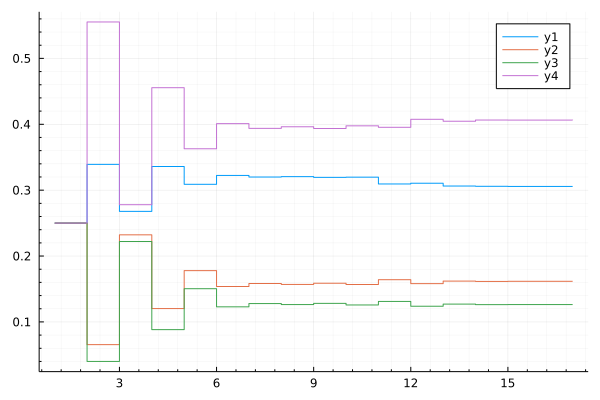

In [79]:
λ_trace = copy(x_trace)
for i in eachindex(x_trace)
   λ_trace[i] .= softmax(x_trace[i])
end

plt = plot( [λ_trace[i][1] for i in eachindex(x_trace)], line=:steppost, minorgrid=true)
for s in 2:S
    plot!( [λ_trace[i][s] for i in eachindex(x_trace)], line=:steppost)
end
plt

In [80]:
println(_Optimizer)


 * Algorithm: BFGS 

 * Linesearch: Bisection

 * Iterations

    n = 16

 * Convergence measures

    |x - x'|               = 6.48e-11 ≰ 1.0e-50
    |x - x'|/|x'|          = 6.89e-11 ≰ 4.4e-16
    |f(x) - f(x')|         = 1.51e-13 ≰ 1.0e-50
    |f(x) - f(x')|/|f(x')| = 4.40e-03 ≰ 2.5e-03
    |g(x)|                 = 1.03e-09 ≤ 1.0e-08

 * Candidate solution

    Final solution value:     [3.088793e-01, -3.281486e-01, -5.744252e-01, 5.936945e-01]
    Final objective value:     3.439749e-11




  0.027261 seconds (13 allocations: 192.359 KiB)


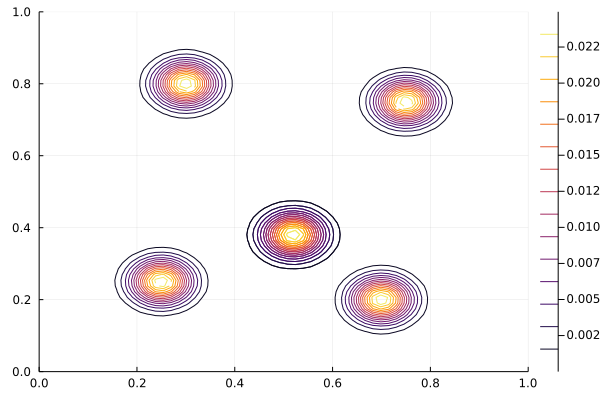

In [82]:
SPB.L = 64
@time q̄ = sinkhorn_barycenter_separated(λ̄, p, k, SPB, caches);
contour(x₁, x₂, [p, q, q̄])

In [83]:
norm(q̄-q,1)

7.667913322457532e-6

In [27]:
@time mysolve!( zeros(S), _Optimizer, x -> callback(x, w2_loss_separated) )

 82.697588 seconds (14.11 M allocations: 757.002 MiB, 0.35% gc time, 12.22% compilation time)


4-element Vector{Float64}:
  0.5677176314010655
 -0.2438053281524754
 -0.6333722390359637
  0.30945993578736763

In [28]:
_Optimizer.status

    i=  20,   rxₐ=6.71329053e-01,   rxᵣ=7.16180506e-01,   ryₐ=6.07139725e-05,   ryᵣ=1.30823301e-01,   rgₐ=4.11992141e-03,   rgᵣ=1.97510764e+00,   

In [29]:
λₒₚₜ = softmax(_Optimizer.status.x)

#=
 0.29406076019381294
 0.15144998426335401
 0.13668583712923285
 0.4178034184136002
=#

4-element Vector{Float64}:
 0.39722839883824135
 0.17644133960876981
 0.1195125703146321
 0.3068176912383566

  0.308781 seconds (13 allocations: 192.578 KiB)


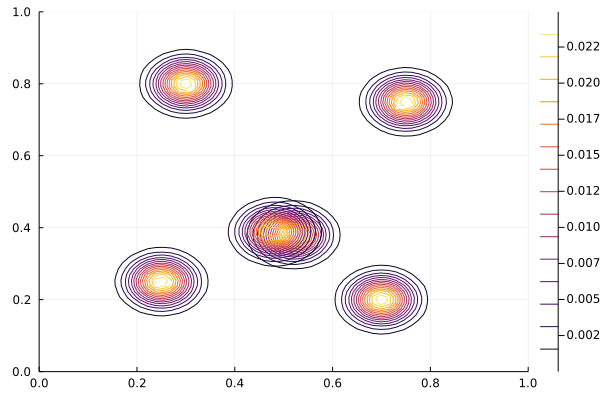

In [30]:
SPB.L = 128

@time qₒₚₜ = sinkhorn_barycenter_separated(λₒₚₜ, p, k, SPB, caches);
contour(x₁, x₂, [p, q, qₒₚₜ])

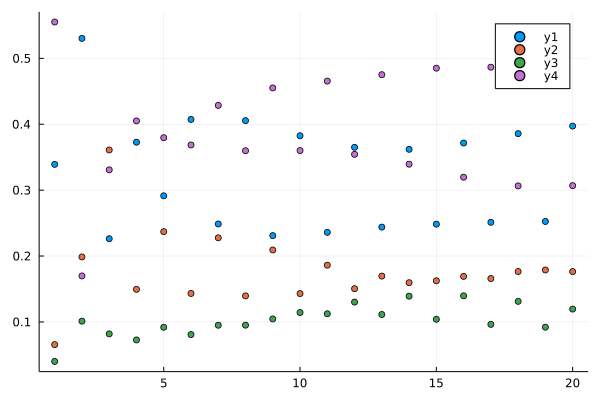

In [31]:
λ_trace = zeros( length(x_trace), S )
for i in eachindex(x_trace)
    for s in 1:S
       λ_trace[i,s] = x_trace[i][s]
    end
end

scatter(λ_trace)

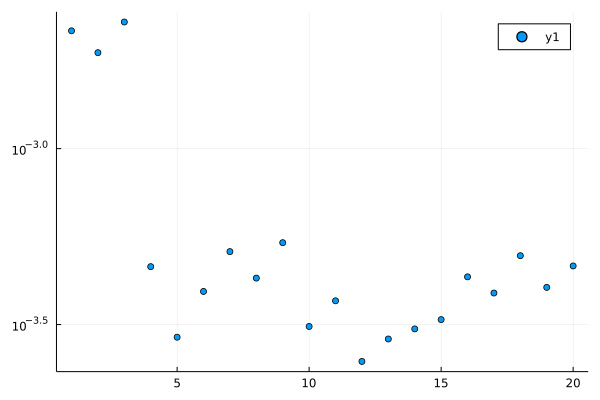

In [32]:
scatter( abs.(y_trace), yaxis = :log)

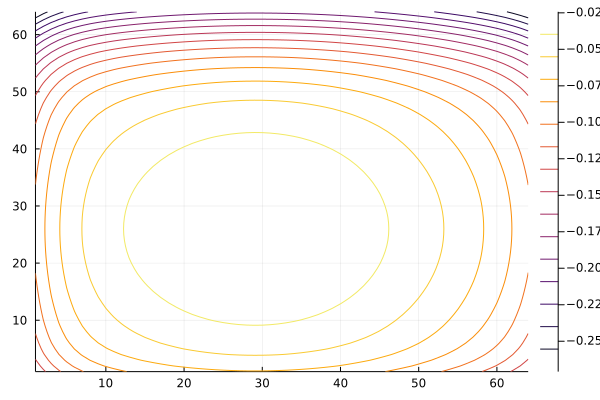

In [33]:
contour(SP.ε * log.(a₀))

In [34]:
using Optim, LineSearches

In [35]:
function optimcallback(x, loss)
    SP.update_potentials = true
    SPB.update_potentials = true

    push!(y_trace, loss(x[end].metadata["x"]) )
    push!(x_trace, softmax(x[end].metadata["x"]))

    SP.update_potentials = false
    SPB.update_potentials = false

    SP.L = 16
    SPB.L = 16

    return false
end

optimcallback (generic function with 1 method)

In [36]:
SP.update_potentials = false
SPB.update_potentials = false

SP.averaged_updates = false

λ₀ = zeros(S) ./ S

a₀ = ones(size(p[1]))
b₀ = ones(size(p[1]))
d₀₁ = ones(size(p[1]))
d₀₂ = ones(size(p[1]))
b_₀ = [ones(size(p[s])) for s in eachindex(p)] 
d₀ = ones(size(p[1]));

x_trace = [ ]
y_trace = [ ]


SP.L = 32
SPB.L = 32

32

In [37]:
@time result = optimize(w2_loss_separated,
                        zeros(S),
                        #LBFGS(linesearch = LineSearches.Static()),
                        #LBFGS(),                        
                        LBFGS(  m=10, 
                                linesearch = LineSearches.BackTracking( c_1=1e-6, iterations = 100),
                                alphaguess = LineSearches.InitialStatic()),
                        #AcceleratedGradientDescent(linesearch = LineSearches.BackTracking(),
                        #                        alphaguess = LineSearches.InitialStatic()),
                        Optim.Options(  callback = x -> optimcallback(x, w2_loss_separated),
                                        iterations = 64,
                                        allow_f_increases = true,
                                        store_trace = true,
                                        extended_trace = true,
                                        g_tol = 1e-4,
                                        f_tol = 1e-3),
                        autodiff=:forward)

  5.128209 seconds (5.83 M allocations: 378.079 MiB, 2.60% gc time, 67.70% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     1.949368e-06

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.82e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.58e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.04e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.56e+00 ≰ 1.0e-03
    |g(x)|                 = 7.20e-05 ≤ 1.0e-04

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    4
    f(x) calls:    5
    ∇f(x) calls:   5


In [38]:
wₒₚₜ = Optim.minimizer(result)
λₒₚₜ = softmax(wₒₚₜ)

4-element Vector{Float64}:
 0.29406076019381294
 0.15144998426335401
 0.13668583712923285
 0.4178034184136002

  0.660284 seconds (13 allocations: 192.578 KiB)


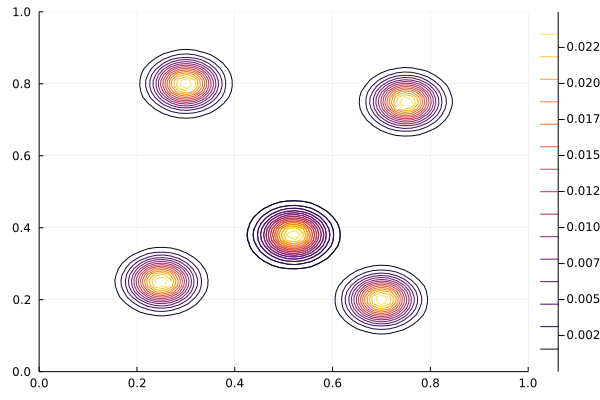

In [39]:
SPB.L = 256

@time qₒₚₜ = sinkhorn_barycenter_separated(λₒₚₜ, p, k, SPB, caches);
contour(x₁, x₂, [p, q, qₒₚₜ])

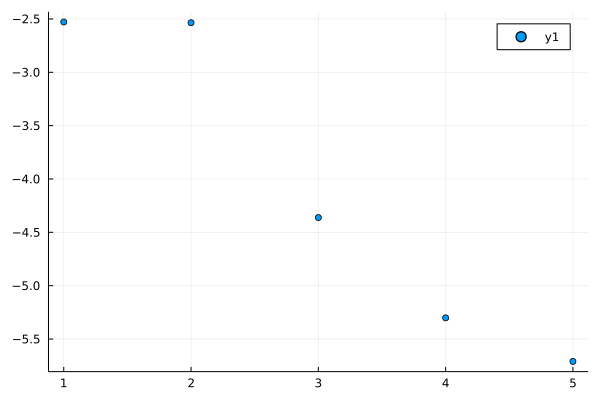

In [40]:
scatter(log10.(abs.([result.trace[i].value for i in eachindex(Optim.trace(result))])))

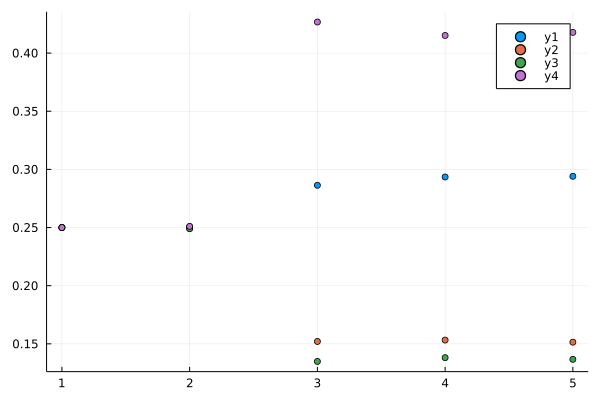

In [41]:
λ_trace = zeros( length(x_trace), S )
for i in eachindex(x_trace)
    for s in 1:S
       λ_trace[i,s] = x_trace[i][s]
    end
end

scatter(λ_trace)

In [46]:
fieldnames(typeof(result))

(:method, :initial_x, :minimizer, :minimum, :iterations, :iteration_converged, :x_converged, :x_abstol, :x_reltol, :x_abschange, :x_relchange, :f_converged, :f_abstol, :f_reltol, :f_abschange, :f_relchange, :g_converged, :g_abstol, :g_residual, :f_increased, :trace, :f_calls, :g_calls, :h_calls, :ls_success, :time_limit, :time_run, :stopped_by)

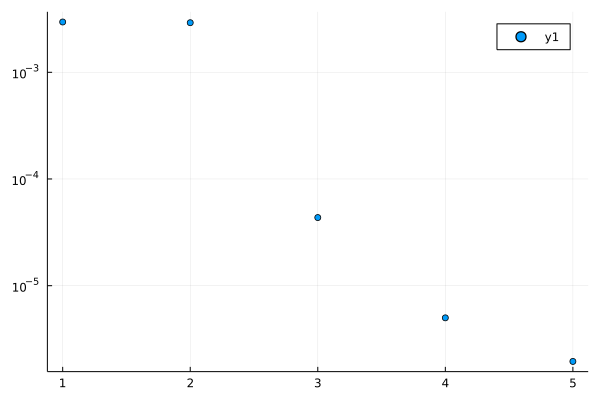

In [43]:
scatter( (y_trace), yaxis = :log)

In [325]:
function cb_last(x, SP, SPB)
    #SP.warmstart = "last_update"
    #SP.update_warmstart = true
    #SP.L = 2

    SPB.warmstart = "last_update"
    SPB.update_warmstart = true
    SPB.L = 8
    
    #print("$(x[end].value)\n")
    
    x[end].value < 1e-9 ? true : false
end

function cb_latest(x, SP, SPB)
    SP.warmstart = "latest"
    SP.L = 2
    SPB.warmstart = "latest"
    SPB.L = 4

    #print("$(x[end].value)\n")
    
    x[end].value < 1e-9 ? true : false
end

L_max = 32
BL_max = 64

function cb_ones(x, SP, SPB)
    SP.warmstart = "ones"
    SPB.warmstart = "ones"
    SP.L + 1 > L_max ? SP.L = L_max : SP.L += 1
    SPB.L + 2 > BL_max ? SPB.L = BL_max : SPB.L += 2

    x[end].value < 1e-9 ? true : false
end

cb_ones (generic function with 1 method)

In [117]:
caches = ( MC = MatrixCache(S,n), VMC = VectorMatrixCache(S,n), VC = VectorCache(S,n) )
caches_N = ( VC = VectorCache(S,n^2) , VVC = VectorVectorCache(S,n^2) )

SP = SinkhornParameters(8, ε_min)
SPB = SinkhornParameters(16, ε_min)

SimpleSolvers.set_config(:nls_atol, 1e-6)
SimpleSolvers.set_config(:nls_rtol, 1e-3)

SimpleSolvers.set_config(:nls_nmax, 64)
SimpleSolvers.set_config(:nls_nmin, 20)

20

In [106]:
@time solve!(zeros(S), _Optimizer)

 34.720173 seconds (3.45 M allocations: 135.025 MiB, 0.16% gc time, 14.75% compilation time)


4-element Vector{Float64}:
  0.6348716966143251
 -0.47603011152629454
 -0.8532099230494332
  0.694368337959437

In [107]:
_Optimizer.status

    i=  20,   rₐ=3.44076870e-08,   rᵣ=6.11582992e-01,   rₛ=2.73380124e-02

In [108]:
_Optimizer.y, _Optimizer.g

(5.626004557526885e-8, [-3.976214232786903e-5, 8.658757303238132e-6, -9.567048897048067e-6, 4.0670433921681906e-5])

In [109]:
softmax(_Optimizer.x)

4-element Vector{Float64}:
 0.38029824515832283
 0.12380090581026079
 0.08811557081688265
 0.4077852782145338

In [118]:
SP.warmstart = "ones"
SPB.warmstart = "ones"
SP.L = 16
SPB.L = 32

@time result = optimize(w2_loss_separated,
                        zeros(S),
                        #LBFGS(linesearch = LineSearches.Static()),
                        #LBFGS(),                        
                        LBFGS(  m=10, 
                                linesearch = LineSearches.BackTracking( c_1=1e-6, iterations = 100),
                                alphaguess = LineSearches.InitialStatic()),
                        #AcceleratedGradientDescent(linesearch = LineSearches.BackTracking(),
                        #                        alphaguess = LineSearches.InitialStatic()),
                        Optim.Options(  callback = x -> cb_ones(x, SP, SPB),
                                        iterations = 64,
                                        allow_f_increases = true,
                                        store_trace = true,
                                        extended_trace = true,
                                        g_tol = 1e-6,
                                        f_tol = 1e-6),
                        autodiff=:forward)

  4.244742 seconds (569.34 k allocations: 34.564 MiB, 9.10% compilation time)


 * Status: failure

 * Candidate solution
    Final objective value:     8.462998e-10

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.22e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.83e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.93e+00 ≰ 1.0e-06
    |g(x)|                 = 3.10e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    20
    f(x) calls:    23
    ∇f(x) calls:   21


In [117]:
wₒₚₜ = Optim.minimizer(result)
λₒₚₜ = softmax(wₒₚₜ)

4-element Vector{Float64}:
 0.3579291367610515
 0.09885893824166123
 0.11283687563036665
 0.43037504936692056

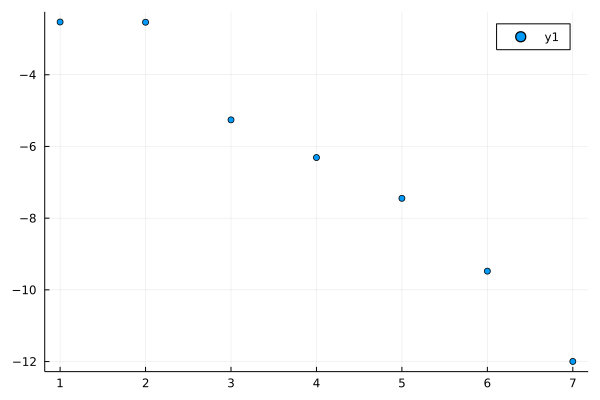

In [165]:
scatter(log10.(abs.([result.trace[i].value for i in eachindex(Optim.trace(result))])))

  0.021014 seconds


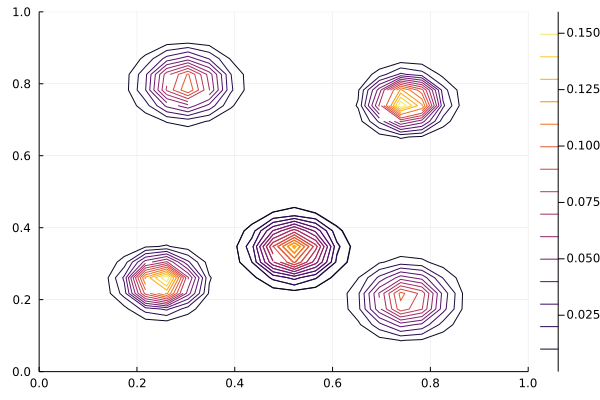

In [49]:
SPB.warmstart="ones"
SP.warmstart="ones"
SPB.L = 64
SP.L = 32
@time qₒₚₜ = wasserstein_barycenter_separated(λₒₚₜ, p, k, SPB, caches);
contour(x₁, x₂, [p, q, qₒₚₜ])

In [50]:
sqrt(wasserstein_distance_separated(qₒₚₜ, q, k, SP, caches)), norm(qₒₚₜ-q,1), norm(qₒₚₜ-q,2)/norm(q,2)

(0.0005679345699344039, 0.012616971083997947, 0.012071466070034408)

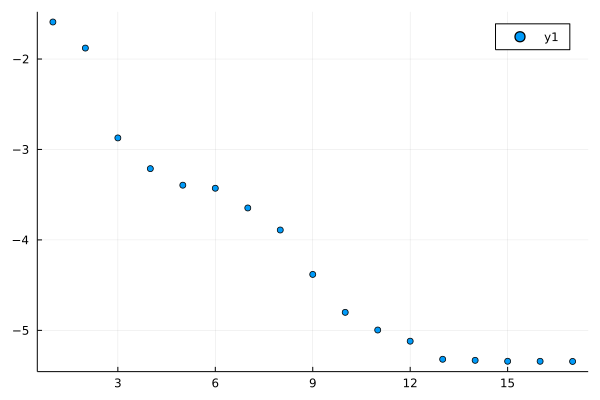

In [61]:
scatter(log10.(abs.([result.trace[i].value for i in eachindex(Optim.trace(result))])))

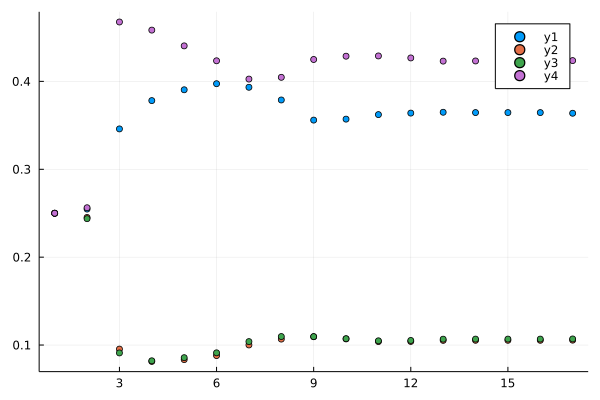

In [62]:
sct = scatter([exp.(Optim.x_trace(result)[i][1]) / sum(exp.(Optim.x_trace(result)[i]))  for i in 1:length(Optim.x_trace(result)) ] )
for j in 2:length(λ₀)
    scatter!([exp.(Optim.x_trace(result)[i][j]) / sum(exp.(Optim.x_trace(result)[i])) for i in 1:length(Optim.x_trace(result)) ] )
end
sct

# Gradient Experiments

In [132]:
logcaches = ( MC = MatrixCache(S,n), VC = VectorCache(S,n) )

SP = SinkhornParameters(32, ε_min)
k₀ = get_gibbs_matrix_separated(c, ε_min);
wasserstein_distance_separated(p[1], p[2], k₁, SP, caches)

0.4121817665364057

In [82]:
#_f = α -> wasserstein_distance_logseparated(log.(softmax(α)), log.(p[1]), c, SP, logcaches)
_f = α -> wasserstein_distance_separated(α, p[1], k₀, SP, caches)
_g = α -> ForwardDiff.gradient(_f, α)

#56 (generic function with 1 method)

In [83]:
@time _f((p[2]))

  0.011311 seconds (716 allocations: 47.687 KiB, 88.40% compilation time)


0.7107971986951044

In [84]:
@time g_ad = _g((p[2]));

  6.671642 seconds (9.37 M allocations: 455.272 MiB, 4.61% gc time, 90.15% compilation time)


In [85]:
MC = caches.MC;

In [86]:
g_man = SP.ε * ( log.(MC[:a, Float64] ./ MC[:d₁, Float64] ) );

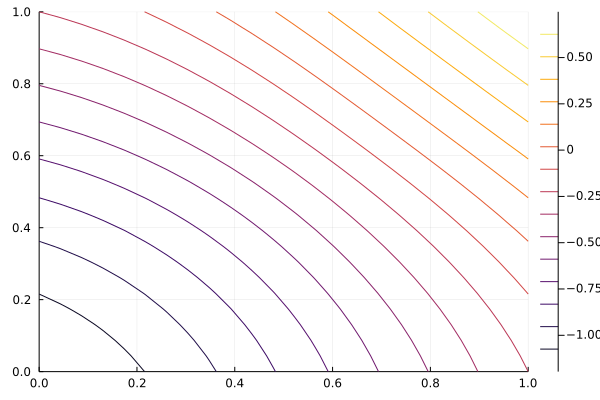

In [87]:
contour( x₁, x₂, g_man )

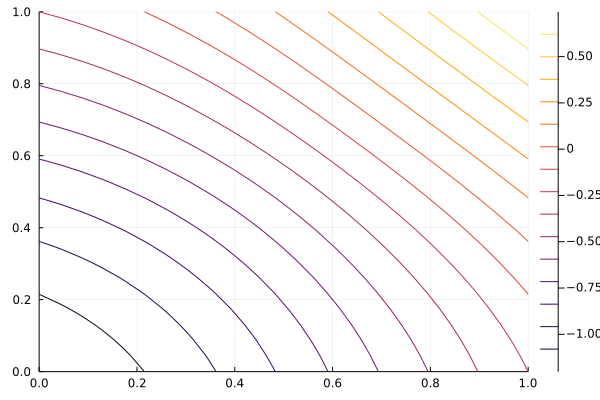

In [88]:
contour( x₁, x₂, g_ad )

In [89]:
norm(g_man - g_ad)/norm(g_man)

0.008966133428950014

In [90]:
norm(g_man - g_ex)/norm(g_ex)

0.008908009459128091

In [91]:
norm(g_ex - g_ad)/norm(g_ex)

5.7078351862476856e-5

In [55]:
g_ex = copy(g_ad);

# Barycenter Gradients

In [185]:
include("../src/sinkhorn_separated.jl")

wasserstein_barycenter_separated

In [177]:
m_fix = copy(m₀);
λ = ones(S)/S;

In [186]:
SP = SinkhornParameters(64, ε_min)
SPB = SinkhornParameters(32, ε_min)

_f = α -> wasserstein_distance_separated(α, p[1], k₁, SP, caches)
_g = α -> ForwardDiff.gradient(_f, α)
VMC = caches.VMC;
MC = caches.MC;

In [187]:
g_ad = _g(p[2]);
_f(p[2])

ErrorException: type Float64 has no field value

In [188]:
g_man = SP.ε * ( log.(MC[:a, Float64] ./ MC[:d₁, Float64] ) );

In [189]:
norm(g_man - g_ad) / norm(g_man)

3.0160156519178307e-17

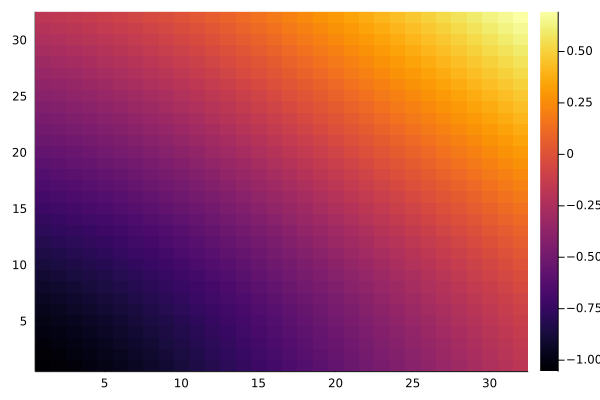

In [190]:
heatmap(g_man)

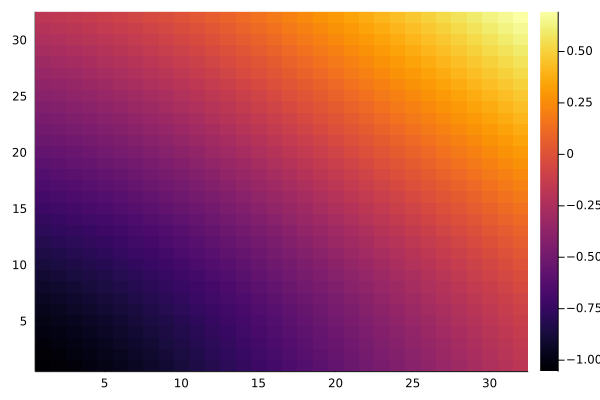

In [191]:
heatmap(g_ad)

In [192]:
g_ad

32×32 Matrix{Float64}:
 -1.05572   -1.04173   -1.02624   …  -0.245861   -0.213626   -0.181461
 -1.04173   -1.02775   -1.01226      -0.231875   -0.19964    -0.167475
 -1.02624   -1.01226   -0.996764     -0.216383   -0.184148   -0.151982
 -1.00925   -0.995261  -0.979768     -0.199387   -0.167152   -0.134986
 -0.990751  -0.976765  -0.961273     -0.180892   -0.148656   -0.116491
 -0.970763  -0.956777  -0.941285  …  -0.160903   -0.128668   -0.0965026
 -0.949291  -0.935305  -0.919813     -0.139432   -0.107197   -0.0750311
 -0.926352  -0.912366  -0.896873     -0.116492   -0.0842567  -0.0520912
 -0.901966  -0.88798   -0.872488     -0.0921063  -0.0598711  -0.0277056
 -0.876169  -0.862183  -0.846691     -0.0663097  -0.0340745  -0.00190899
  ⋮                               ⋱               ⋮          
 -0.439404  -0.425417  -0.409925      0.370456    0.402691    0.434857
 -0.407146  -0.39316   -0.377667      0.402714    0.434949    0.467115
 -0.374888  -0.360902  -0.345409  …   0.434972    0.46720

In [194]:
ForwardDiff.Dual(1.0).value

1.0

In [201]:
ForwardDiff.value.(ForwardDiff.Dual.(rand(3)))

3-element Vector{Float64}:
 0.989345545070031
 0.07693523543410041
 0.5532614474227731

In [142]:
_fb = α -> wasserstein_barycenter_separated(α, p, k₁, SPB, caches)
_gb = α -> ForwardDiff.jacobian(_fb, α)

#121 (generic function with 1 method)

In [143]:
@time gb_ad = _gb(λ);

 11.304917 seconds (11.94 M allocations: 650.003 MiB, 2.29% gc time, 99.17% compilation time)


In [146]:
m₀ = _fb(λ);
g_ad = _g(m₀);
_f(m₀)

0.13145528493006897

In [281]:
g_man = SP.ε * ( log.(MC[:a, Float64] ./ MC[:d₁, Float64] ) );

In [283]:
_ffull = α -> _f(_fb(α))
_gfull = α -> ForwardDiff.gradient(_ffull, α)

#180 (generic function with 1 method)

In [286]:
@time gfull_ad = _gfull(λ);

  0.555871 seconds (3.85 k allocations: 210.719 KiB)


In [288]:
gfull_man = zeros(S)
gfull_halfman = zeros(S)
for s in eachindex(gfull_man)
    for i in eachindex(g_man)
        # gfull_man[s] += g_man[i] * ∂μ_man[s][i]
        gfull_halfman[s] += g_man[i] * gb_ad[i,s]
    end
end

In [291]:
g_mu_ex = copy(gb_ad)
g_full_ex = copy(gfull_ad);

In [292]:
norm( gb_ad - g_mu_ex ) / norm(g_mu_ex)

0.0

In [293]:
norm( gfull_ad - gfull_halfman ) / norm( gfull_ad )

1.9650801791023362e-6

In [294]:
norm( gfull_ad - g_full_ex ) / norm(g_full_ex)

0.0

In [295]:
norm( gfull_halfman - g_full_ex ) / norm(g_full_ex)

1.9650801791023362e-6

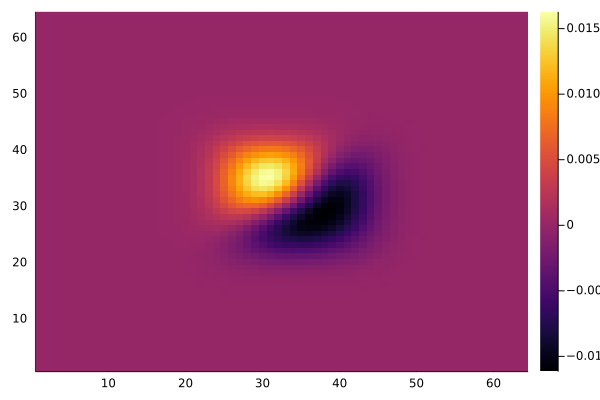

In [300]:
heatmap(reshape(gb_ad[:,3], (n,n)) )

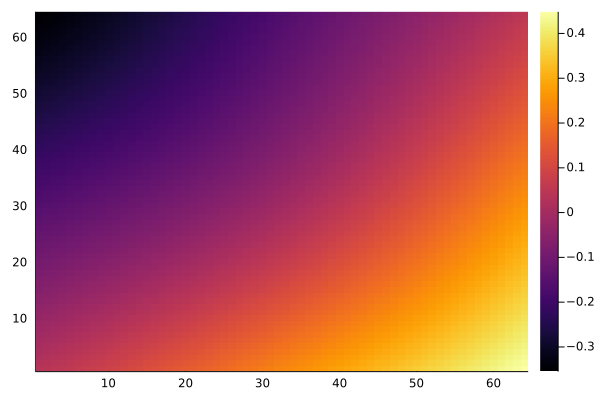

In [301]:
heatmap(g_man)

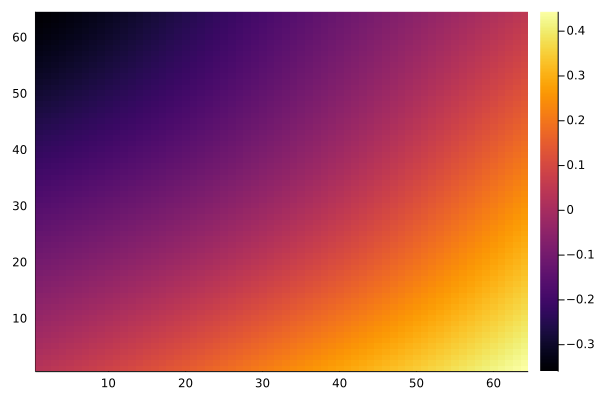

In [306]:
heatmap(g_ad)

In [302]:
gfull_ad

4-element Vector{Float64}:
 -0.01411549374009163
  0.0007108319274028019
 -0.17391251629243962
  0.17903877406343782

In [303]:
sum(reshape(gb_ad[:,4], (n,n)) .* g_man)

0.179038997243599

In [318]:
@time _f(m0);

  0.006342 seconds (2 allocations: 32 bytes)


In [257]:
@time _g(m0);

  6.683660 seconds (442.85 k allocations: 23.714 MiB)


In [258]:
@time _gb(λ);

  0.620278 seconds (52.23 k allocations: 2.807 MiB)


In [312]:
@time _gfull(λ)

  0.543605 seconds (3.85 k allocations: 210.719 KiB)


4-element Vector{Float64}:
 -0.01411549374009163
  0.0007108319274028019
 -0.17391251629243962
  0.17903877406343782

In [313]:
@time _ffull(λ)

  0.157180 seconds (2 allocations: 32 bytes)


0.08593325311332485

In [330]:
function _seperated_mul(c, a)
    r = zero(a)
    n = size(a,1)
    r1 = zeros(n)
    r2 = zeros(n)
    for i₁ in 1:n
        for j₁ in 1:n
            for j₂ in 1:n
                r1[i₁] += c[1][i₁,j₁] * a[j₁,j₂]
            end
        end
    end
    for i₂ in 1:n
        for j₁ in 1:n
            for j₂ in 1:n
                r2[i₂] += c[2][i₂,j₂] * a[j₁,j₂]
            end
        end
    end
    for i₁ in 1:n
        for i₂ in 1:n
            r[i₁,i₂] = r1[i₁] + r2[i₂]
        end
    end
    return r
end

_seperated_mul (generic function with 1 method)

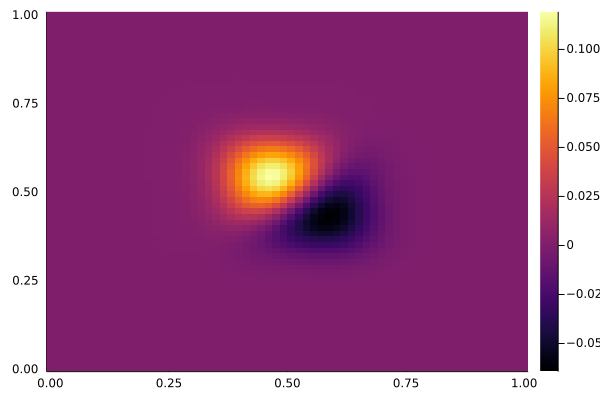

In [351]:
heatmap(x₁, x₂, m0 .* log.(caches.VMC[:φ, Float64][3]) ./ norm(m0 .* log.(caches.VMC[:φ, Float64][3])) )

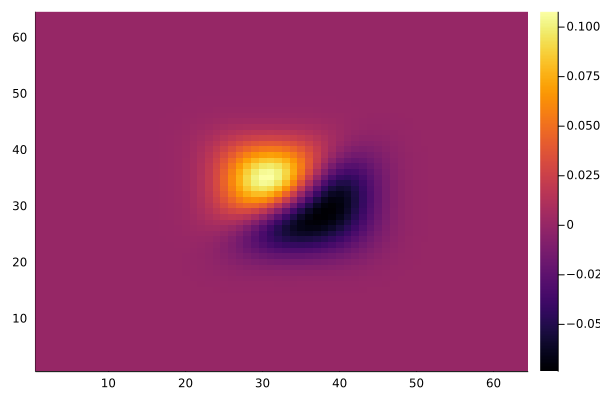

In [352]:
heatmap(reshape(gb_ad[:,3], (n,n)) ./ norm(gb_ad[:,3]) )